![Roboflow Notebooks banner](https://camo.githubusercontent.com/aec53c2b5fb6ed43d202a0ab622b58ba68a89d654fbe3abab0c0cc8bd1ff424e/68747470733a2f2f696b2e696d6167656b69742e696f2f726f626f666c6f772f6e6f7465626f6f6b732f74656d706c6174652f62616e6e657274657374322d322e706e673f696b2d73646b2d76657273696f6e3d6a6176617363726970742d312e342e33267570646174656441743d31363732393332373130313934)

# Image Classification with DINOv2

DINOv2, released by Meta Research in April 2023, implements a self-supervised method of training computer vision models.

DINOv2 was trained using 140 million images without labels. The embeddings generated by DINOv2 can be used for classification, image retrieval, segmentation, and depth estimation. With that said, Meta Research did not release heads for segmentation and depth estimation.

In this guide, we are going to build an image classifier using embeddings from DINOv2. To do so, we will:

1. Load a folder of images
2. Compute embeddings for each image
3. Save all the embeddings in a file and vector store
4. Train an SVM classifier to classify images

We'll be using the [MIT Indoor Scene Recognition dataset](https://universe.roboflow.com/popular-benchmarks/mit-indoor-scene-recognition/) in this project, but you can use any labelled classification dataset you have.

By the end of this notebook, we'll have a classifier trained on our dataset.

Without further ado, let's begin!

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: extract 7z file

!7z x '/content/drive/MyDrive/NEW_DATA_AUGMENTED_DATASET.7z' -o'/content'



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 817283648 bytes (780 MiB)

Extracting archive: /content/drive/MyDrive/NEW_DATA_AUGMENTED_DATASET.7z
--
Path = /content/drive/MyDrive/NEW_DATA_AUGMENTED_DATASET.7z
Type = 7z
Physical Size = 817283648
Headers Size = 94779
Method = LZMA2:26
Solid = +
Blocks = 1

  0%      1% 137 - NEW_DATA_AUGMENTED_DATASET/Normal/aug_0_1480.png                                                             3% 271 - NEW_DATA_AUGMENTED_DATASET/Normal/aug_0_2050.png

In [ ]:
# prompt: extract the zip folder

!unzip /content/drive/MyDrive/test.zip -d /content


Archive:  /content/drive/MyDrive/test.zip
  inflating: /content/Normal/Normal_100x_12.jpg  
  inflating: /content/Normal/Normal_100x_2.jpg  
  inflating: /content/Normal/Normal_100x_21.jpg  
  inflating: /content/Normal/Normal_100x_22.jpg  
  inflating: /content/Normal/Normal_100x_25.jpg  
  inflating: /content/Normal/Normal_100x_35.jpg  
  inflating: /content/Normal/Normal_100x_38.jpg  
  inflating: /content/Normal/Normal_100x_41.jpg  
  inflating: /content/Normal/Normal_100x_72.jpg  
  inflating: /content/Normal/Normal_100x_83.jpg  
  inflating: /content/Normal/Normal_400x_104.jpg  
  inflating: /content/Normal/Normal_400x_105.jpg  
  inflating: /content/Normal/Normal_400x_106.jpg  
  inflating: /content/Normal/Normal_400x_119.jpg  
  inflating: /content/Normal/Normal_400x_12.jpg  
  inflating: /content/Normal/Normal_400x_122.jpg  
  inflating: /content/Normal/Normal_400x_124.jpg  
  inflating: /content/Normal/Normal_400x_130.jpg  
  inflating: /content/Normal/Normal_400x_149.jpg  
 

In [ ]:
# prompt: move Normal files to test
!mv /content/OSCC/* /content/test/

## Import Packages

First, let's import the packages we will need for this project.

In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm

## Load Data



In [ ]:
pip install roboflow supervision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import supervision as sv

In [ ]:
cwd = os.getcwd()


ROOT_DIR = os.path.join("/content/NEW_DATA_AUGMENTED_DATASET/")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

## Load the Model and Compute Embeddings

To train our classifier, we need:

1. The embeddings associated with each image in our dataset, and;
2. The labels associated with each image.

To calculate embeddings, we'll use DINOv2. Below, we load the smallest DINOv2 weights and define functions that will load and compute embeddings for every image in a specified list.

We store all of our vectors in a dictionary that is saved to disk so we can reference them again if needed. Note that in production environments one may opt for using another data structure such as a vector embedding database (i.e. faiss) for storing embeddings.

In [ ]:
dinov2_vits14= torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(), T.Resize(224), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 99.8MB/s]


In [ ]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}

    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

## Compute Embeddings

The code below computes the embeddings for all the images in our dataset. This step will take a few minutes for the MIT Indoor Scene Recognition dataset. There are over 10,000 images in the training set that we need to pass through DINOv2.

In [ ]:
embeddings = compute_embeddings(files)

  0%|          | 0/8570 [00:00<?, ?it/s]

In [ ]:
y = [labels[file] for file in files]

In [ ]:
print(len(y))

8570


In [ ]:
print(set(y))

{'OSCC', 'Normal'}


In [ ]:
# prompt: delete /content/test/Normal

!rm -rf /content/test/.ipynb_checkpoints/


## Train a Classification Model

The embeddings we have computed can be used as an input in a classification model. For this guide, we will be using SVM, a linear classification model.

Below, we make lists of both all of the embeddings we have computed and their associated labels. We then fit our model using those lists.

# SVM

>



In [ ]:
# prompt: in above module fit the data using standard scaler
from sklearn import svm
from sklearn.preprocessing import *
clf_svm= svm.SVC(kernel="poly",degree=3,random_state=42)
embedding_list = list(embeddings.values())
clf_svm.fit((np.array(embedding_list).reshape(-1, 384)), y)

predictions_svm = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction_svm = clf_svm.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_svm.append(prediction_svm[0])


# Random Forest




In [ ]:
# prompt: implement the random forest by using above module

import numpy as np
from sklearn.ensemble import RandomForestClassifier
clf_rf= RandomForestClassifier(n_estimators=100,random_state=42,criterion='gini')
clf_rf.fit((np.array(embedding_list).reshape(-1, 384)), y)

predictions_rf  = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))

        prediction_rf = clf_rf.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_rf.append(prediction_rf[0])

# AdaBoost

In [ ]:
# prompt: implement the ada boost by using above module

import numpy as np
from sklearn.ensemble import AdaBoostClassifier

clf_ad= AdaBoostClassifier(n_estimators=100,random_state=42)

clf_ad.fit((np.array(embedding_list).reshape(-1, 384)), y)

predictions_ad  = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))

        prediction_ad = clf_ad.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_ad.append(prediction_ad[0])

#KNN

In [ ]:
# prompt: implement the knn using above module

import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with k = 3
clf_knn = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier using the embeddings and labels
clf_knn.fit((np.array(embedding_list).reshape(-1, 384)), y)
predictions_knn  = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction_knn = clf_knn.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_knn.append(prediction_knn[0])

#GNB


In [ ]:
# prompt: implement the naive bayes using above module
import numpy as np
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb.fit((np.array(embedding_list).reshape(-1, 384)), y)

predictions_nb  = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction_nb = clf_nb.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_nb.append(prediction_nb[0])

#DTree


In [ ]:

# # prompt: implement the decision tree  using above module
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier(criterion='log_loss',max_features="sqrt",random_state=42)
clf_tree.fit((np.array(embedding_list).reshape(-1, 384)), y)

predictions_tree = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction_tree = clf_tree.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_tree.append(prediction_tree[0])


#Logistic Regression





In [ ]:
# prompt: # prompt: implement the logistic regression  using above module
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(random_state=0)

clf_log.fit((np.array(embedding_list).reshape(-1, 384)), y)

predictions_log  = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction_log = clf_log.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_log.append(prediction_log[0])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

#MLP classifier

In [ ]:
# prompt: # prompt: implement the artificial neural networks using above module
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000)
clf_mlp.fit((np.array(embedding_list).reshape(-1, 384)), y)


predictions_mlp  = []
for input_file in sorted(os.listdir("/content/test/")):
    # print(input_file)
    new_image = load_image("/content/test/"+input_file)
    with torch.no_grad():
        embedding = dinov2_vits14(new_image.to(device))
        prediction_mlp = clf_mlp.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
        predictions_mlp.append(prediction_mlp[0])

MLPClassifier(max_iter=1000)

## Classify an Image

We now have a classifier we can use to classify images!

Change the `input_file` value below to the path of a file in the `valid` or `test` directories in the image dataset with which we have been working.

Then, run the cell to classify the image.

In [ ]:
test_labels=[]
for input_file in sorted(os.listdir("/content/test/")):
        if 'Normal' in input_file:
            test_labels.append('Normal')
        else:
            test_labels.append('OSCC')


In [ ]:
# predictions_svm = []
# predictions_rf  = []
# predictions_ad  = []
# predictions_knn  = []
# predictions_nb  = []
# predictions_tree = []
# predictions_log  = []
# predictions_mlp  = []
# for input_file in sorted(os.listdir("/content/test/")):
#     # print(input_file)
#     new_image = load_image("/content/test/"+input_file)
#     with torch.no_grad():
#         embedding = dinov2_vits14(new_image.to(device))
#         prediction_svm = clf_svm.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_svm.append(prediction_svm[0])

#         prediction_rf = clf_rf.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_rf.append(prediction_rf[0])

#         prediction_ad = clf_ad.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_ad.append(prediction_ad[0])

#         prediction_knn = clf_knn.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_knn.append(prediction_knn[0])

#         prediction_nb = clf_nb.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_nb.append(prediction_nb[0])

#         prediction_tree = clf_tree.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_tree.append(prediction_tree[0])

#         prediction_log = clf_log.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_log.append(prediction_log[0])

#         prediction_mlp = clf_mlp.predict(np.array(embedding[0].cpu()).reshape(1, -1)) # model with train embeddings
#         predictions_mlp.append(prediction_mlp[0])


# **Model Evaluation by SVM predictions**

Normal count 29
OSCC count 97

Accuracy: 93.65079365079364
Precision: 0.9484536082474226
Recall: 0.968421052631579
F1 Score: 0.9583333333333333

              precision    recall  f1-score   support

      Normal       0.90      0.84      0.87        31
        OSCC       0.95      0.97      0.96        95

    accuracy                           0.94       126
   macro avg       0.92      0.90      0.91       126
weighted avg       0.94      0.94      0.94       126




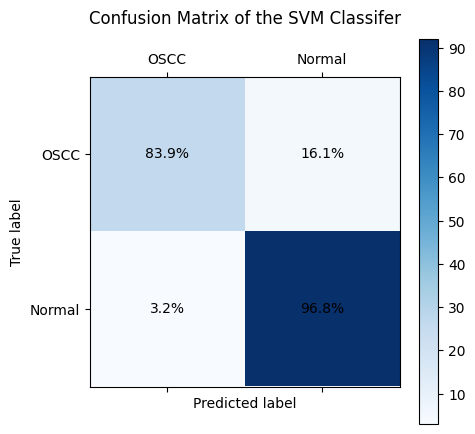

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_svm:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1

print('Normal count',normal_count)
print('OSCC count', OSCC_count)
print()
# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_svm)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print()

# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_svm))

print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_svm)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the SVM Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()


# **Model Evaluation by Random Forest predictions**

normal_count  28
OSCC_count  98

Accuracy: 89.68253968253968
Precision: 0.9183673469387755
Recall: 0.9473684210526315
F1 Score: 0.9326424870466321

              precision    recall  f1-score   support

      Normal       0.82      0.74      0.78        31
        OSCC       0.92      0.95      0.93        95

    accuracy                           0.90       126
   macro avg       0.87      0.84      0.86       126
weighted avg       0.89      0.90      0.90       126



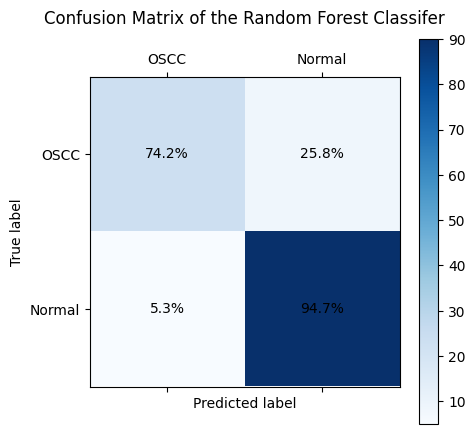

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_rf:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1

print('normal_count ',normal_count)
print('OSCC_count ',OSCC_count)

print()

# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_rf)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

print()

# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_rf))

# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_rf)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the Random Forest Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()


# **Model Evaluation by Ada Boost predictions**


normal_count 29
OSCC_count 97

Accuracy: 80.95238095238095
Precision: 0.865979381443299
Recall: 0.8842105263157894
F1 Score: 0.8749999999999999

              precision    recall  f1-score   support

      Normal       0.62      0.58      0.60        31
        OSCC       0.87      0.88      0.87        95

    accuracy                           0.81       126
   macro avg       0.74      0.73      0.74       126
weighted avg       0.81      0.81      0.81       126




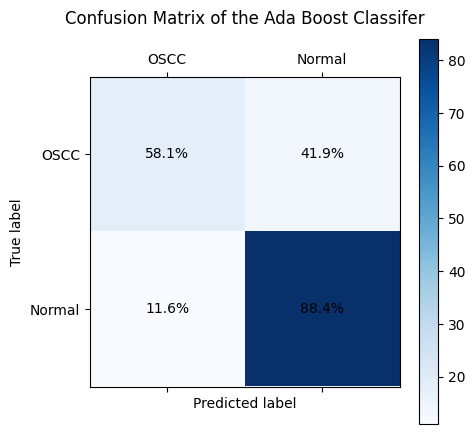

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_ad:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1

print('normal_count',normal_count)
print('OSCC_count',OSCC_count)

print()
# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_ad)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print()

# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_ad))



print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_ad)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the Ada Boost Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()


# **Model Evaluation by KNN predictions**


normal_count  33
OSCC_count  93

Accuracy: 93.65079365079364
Precision: 0.967741935483871
Recall: 0.9473684210526315
F1 Score: 0.9574468085106383

              precision    recall  f1-score   support

      Normal       0.85      0.90      0.88        31
        OSCC       0.97      0.95      0.96        95

    accuracy                           0.94       126
   macro avg       0.91      0.93      0.92       126
weighted avg       0.94      0.94      0.94       126





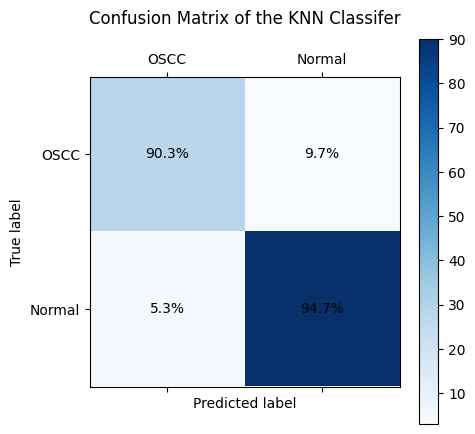

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_knn:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1

print('normal_count ',normal_count )
print('OSCC_count ',OSCC_count)
print()
# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_knn)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_knn))

print()
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_knn)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the KNN Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Model Evaluation by Gausian Naive Bayes predictions**


normal_count  49
OSCC_count  77

Accuracy: 74.60317460317461
Precision: 0.9090909090909091
Recall: 0.7368421052631579
F1 Score: 0.813953488372093

              precision    recall  f1-score   support

      Normal       0.49      0.77      0.60        31
        OSCC       0.91      0.74      0.81        95

    accuracy                           0.75       126
   macro avg       0.70      0.76      0.71       126
weighted avg       0.81      0.75      0.76       126





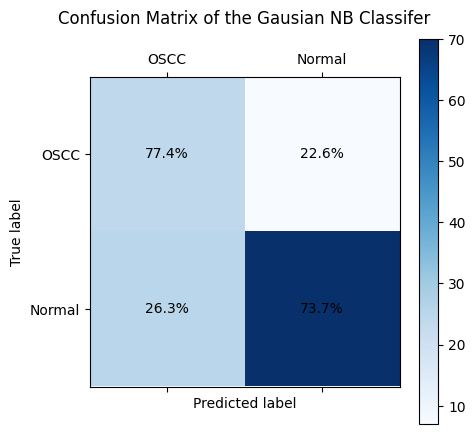

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_nb:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1

print('normal_count ',normal_count )
print('OSCC_count ',OSCC_count)
print()
# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_nb)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_nb))

print()
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_nb)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the Gausian NB Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()

# **Model Evaluation by Decision tree predictions**


normal_count  38
OSCC_count  88

Accuracy: 72.22222222222221
Precision: 0.8409090909090909
Recall: 0.7789473684210526
F1 Score: 0.808743169398907

              precision    recall  f1-score   support

      Normal       0.45      0.55      0.49        31
        OSCC       0.84      0.78      0.81        95

    accuracy                           0.72       126
   macro avg       0.64      0.66      0.65       126
weighted avg       0.74      0.72      0.73       126





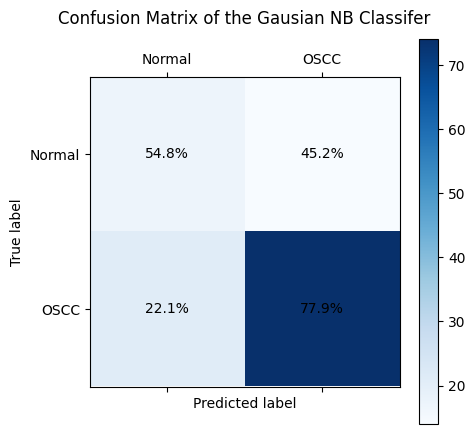

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_tree:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1


print('normal_count ',normal_count )
print('OSCC_count ',OSCC_count)
print()
# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_tree)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_tree))

print()
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_tree)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the Decision Tree Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()

normal_count  30
OSCC_count  96

Accuracy: 88.09523809523809
Precision: 0.9166666666666666
Recall: 0.9263157894736842
F1 Score: 0.9214659685863874

              precision    recall  f1-score   support

      Normal       0.77      0.74      0.75        31
        OSCC       0.92      0.93      0.92        95

    accuracy                           0.88       126
   macro avg       0.84      0.83      0.84       126
weighted avg       0.88      0.88      0.88       126





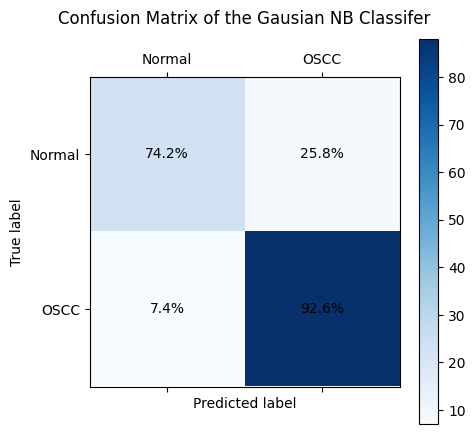

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_log:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1

print('normal_count ',normal_count )
print('OSCC_count ',OSCC_count)
print()
# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_log)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_log))

print()
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_log)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the Gausian NB Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()

normal_count  34
OSCC_count  92

Accuracy: 96.03174603174604
Precision: 0.9891304347826086
Recall: 0.9578947368421052
F1 Score: 0.9732620320855614

              precision    recall  f1-score   support

      Normal       0.88      0.97      0.92        31
        OSCC       0.99      0.96      0.97        95

    accuracy                           0.96       126
   macro avg       0.94      0.96      0.95       126
weighted avg       0.96      0.96      0.96       126





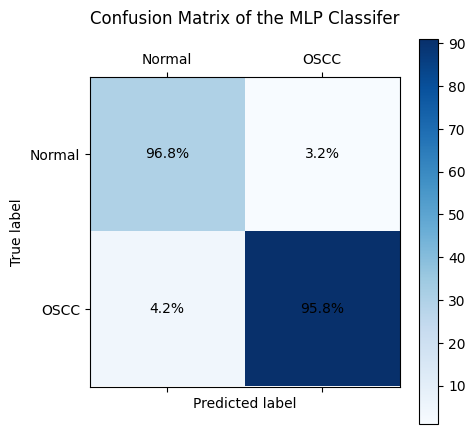

In [ ]:
normal_count=0
OSCC_count=0
for i in predictions_mlp:
  if i=="Normal":
    normal_count+=1
  else:
    OSCC_count+=1

print('normal_count ',normal_count )
print('OSCC_count ',OSCC_count)
print()
# prompt: implement accuracy , precision , recall , f1score  without using methods with neat print

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions_mlp)

# Calculate accuracy
accuracy = (cm[0][0] + cm[1][1]) / len(test_labels) * 100

# Calculate precision
precision = cm[1][1] / (cm[1][1] + cm[0][1])

# Calculate recall
recall = cm[1][1] / (cm[1][1] + cm[1][0])

# Calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

# Calculate evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

print(classification_report(test_labels, predictions_mlp))

print()
print()
# prompt: make model evaluation perfectly and visualization by above classes by above model

import matplotlib.pyplot as plt
import numpy as np
# Create a confusion matrix
y = [labels[file] for file in files]
cm = confusion_matrix(test_labels, predictions_mlp)

# Normalize the confusion matrix
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Create a heatmap and colorbar
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

y_modified=['OSCC','Normal']
# Set labels
ax.set(
    title="Confusion Matrix of the MLP Classifer\n",
    xlabel="Predicted label",
    ylabel="True label",
    xticks=np.arange(len(set(y_modified))),
    yticks=np.arange(len(set(y_modified))),
    xticklabels=set(y_modified),
    yticklabels=set(y_modified),
)

# Label each cell with the corresponding value
for (i, j), z in np.ndenumerate(cm_norm):
    ax.text(j, i, f"{z:.1%}", ha="center", va="center", fontsize=10)

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=0)

# Display the plot
plt.show()

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.